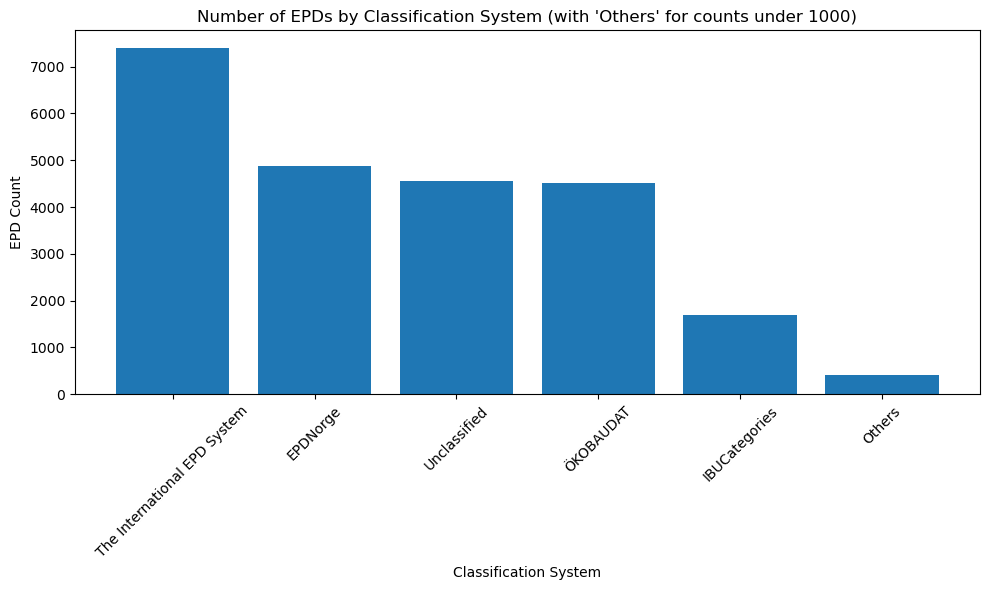

,classification_system,epd_count
0,The International EPD System,7406
1,EPDNorge,4872
2,Unclassified,4551
3,ÖKOBAUDAT,4520
4,IBUCategories,1693
5,Others,411


In [5]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Define the correct path to your EPD database
DB_PATH = "../data/pipeline2/sql/epd_database.sqlite"

# 1. Connect to the database
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

# 2. SQL query:
#    - Use COALESCE to include entries without a classification system by substituting 'no explicit classification'
#    - Convert classification_system values to lowercase for a case-insensitive grouping
#    - Order the results by epd_count in descending order
query = """
    SELECT 
        COALESCE(lower(m.classification_system), 'no explicit classification') AS classification_system,
        COUNT(*) AS epd_count
    FROM epd_documents d
    JOIN epd_metadata m ON d.uuid = m.uuid
    GROUP BY COALESCE(lower(m.classification_system), 'no explicit classification')
    ORDER BY epd_count DESC
"""

cursor.execute(query)
rows = cursor.fetchall()

# 3. Load the results into a pandas DataFrame
df = pd.DataFrame(rows, columns=["classification_system", "epd_count"])

# Always close the connection when done
conn.close()

# 4. Rename the classification systems according to your mapping
mapping = {
    "the international epd system": "The International EPD System",
    "epdnorge": "EPDNorge",
    "no explicit classification": "Unclassified",
    "oekobau.dat": "ÖKOBAUDAT",
    "ibucategories": "IBUCategories"
}
df["classification_system"] = df["classification_system"].replace(mapping)

# 5. Partition the DataFrame into large groups (>= 1000) and small groups (< 1000)
df_large = df[df["epd_count"] >= 1000].copy()
df_small = df[df["epd_count"] < 1000].copy()

# Sum the counts of the small groups and label them "Others"
others_count = df_small["epd_count"].sum()
if others_count > 0:
    df_others = pd.DataFrame([{"classification_system": "Others", "epd_count": others_count}])
    df_final = pd.concat([df_large, df_others], ignore_index=True)
else:
    df_final = df_large.copy()

# 6. Sort the final DataFrame by epd_count in descending order
df_final = df_final.sort_values(by="epd_count", ascending=False)

# 7. Create a bar plot with the classification systems ordered from left (highest count) to right (lowest count)
plt.figure(figsize=(10,6))
plt.bar(df_final["classification_system"], df_final["epd_count"])
plt.title("Number of EPDs by Classification System (with 'Others' for counts under 1000)")
plt.xlabel("Classification System")
plt.ylabel("EPD Count")
plt.xticks(rotation=45)  # Rotate labels for readability
plt.tight_layout()       # Adjust layout to ensure everything fits well
plt.show()

# Display the final DataFrame to verify the data
df_final


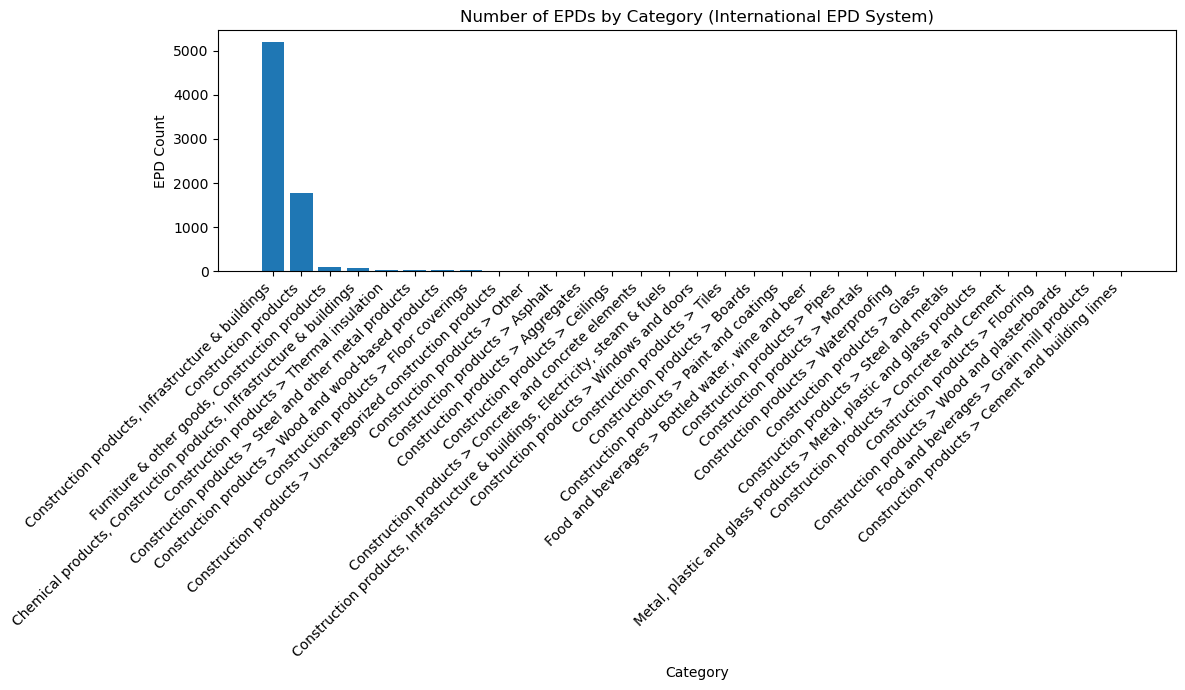

,category,epd_count,percentage
0,"Construction products, Infrastructure & buildings",5199,70.21
1,Construction products,1769,23.89
6,"Furniture & other goods, Construction products",108,1.46
20,"Chemical products, Construction products, Infr...",68,0.92
7,Construction products > Thermal insulation,42,0.57
3,Construction products > Steel and other metal ...,32,0.43
12,Construction products > Wood and wood-based pr...,26,0.35
5,Construction products > Floor coverings,22,0.30
4,Construction products > Uncategorized construc...,21,0.28
11,Construction products > Other,21,0.28


In [9]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import defaultdict

# Define the correct path to your EPD database
DB_PATH = "../data/pipeline2/sql/epd_database.sqlite"

# 1. Connect to the database and fetch documents for "the international epd system"
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

query = """
    SELECT d.document
    FROM epd_documents d
    JOIN epd_metadata m ON d.uuid = m.uuid
    WHERE lower(m.classification_system) = 'the international epd system'
"""
cursor.execute(query)
rows = cursor.fetchall()
conn.close()

# 2. Process each document to extract the category from the JSON path:
#    processInformation.dataSetInformation.classificationInformation.classification[0].class
#    If there are multiple levels, join them with " > "
category_counts = defaultdict(int)

for (doc_str,) in rows:
    try:
        doc = json.loads(doc_str)
    except Exception:
        continue  # Skip invalid JSON documents

    try:
        # Navigate to the classification list
        classes = doc["processInformation"]["dataSetInformation"]["classificationInformation"]["classification"][0]["class"]
    except Exception:
        continue  # Skip documents missing the expected JSON structure

    try:
        # Sort by level and join multiple category levels with " > "
        classes_sorted = sorted(classes, key=lambda x: x.get("level", 0))
        cat_values = [c.get("value", "").strip() for c in classes_sorted if c.get("value", "").strip()]
        if not cat_values:
            continue
        category = " > ".join(cat_values)
        category_counts[category] += 1
    except Exception:
        continue

# 3. Create a DataFrame from the aggregated counts and sort by epd_count descending
df = pd.DataFrame(list(category_counts.items()), columns=["category", "epd_count"])
df = df.sort_values(by="epd_count", ascending=False)

# 4. Add a percentage column showing each category's share relative to the total
total = df["epd_count"].sum()
df["percentage"] = (df["epd_count"] / total) * 100
df["percentage"] = df["percentage"].round(2)

# 5. Plot the results in a bar chart (categories ordered left to right by highest count)
plt.figure(figsize=(12, 7))
plt.bar(df["category"], df["epd_count"])
plt.title("Number of EPDs by Category (International EPD System)")
plt.xlabel("Category")
plt.ylabel("EPD Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Display the DataFrame to verify the data along with the percentage column
df


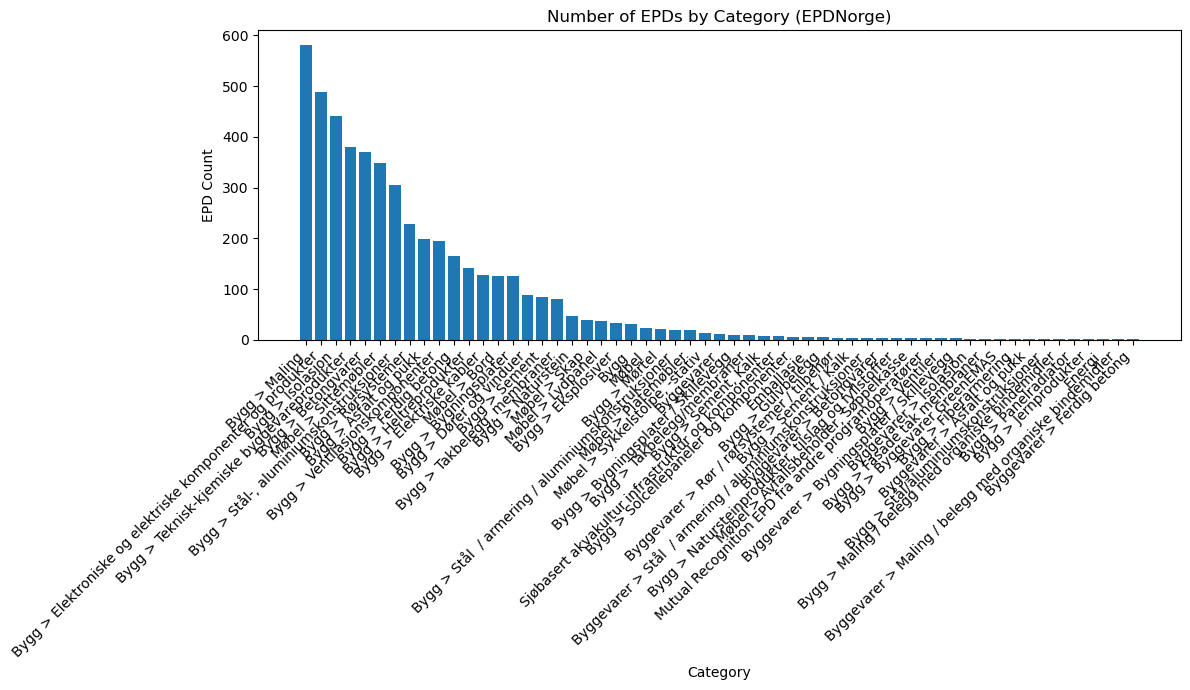

,category,epd_count,percentage
13,Bygg > Maling,581,11.93
8,Bygg > Elektroniske og elektriske komponenter ...,489,10.04
4,Bygg > Isolasjon,441,9.05
6,Bygg > Teknisk-kjemiske byggevareprodukter,381,7.82
1,Bygg > Betongvarer,370,7.59
14,Møbel > Sittemøbler,348,7.14
0,"Bygg > Stål-, aluminiumskonstruksjoner",306,6.28
5,Bygg > Rørsystemer,228,4.68
2,Bygg > Asfalt og pukk,198,4.06
7,Bygg > Ventilasjonskomponenter,195,4.00


In [ ]:
# EPDNorge Categories

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import json
from collections import defaultdict

# Define the correct path to your EPD database
DB_PATH = "../data/pipeline2/sql/epd_database.sqlite"

# 1. Connect to the database and fetch documents for "epdnorge"
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

query = """
    SELECT d.document
    FROM epd_documents d
    JOIN epd_metadata m ON d.uuid = m.uuid
    WHERE lower(m.classification_system) = 'epdnorge'
"""
cursor.execute(query)
rows = cursor.fetchall()
conn.close()

# 2. Process each document to extract the category from the JSON path:
#    processInformation.dataSetInformation.classificationInformation.classification[0].class
#    If there are multiple levels, join them with " > "
category_counts = defaultdict(int)

for (doc_str,) in rows:
    try:
        doc = json.loads(doc_str)
    except Exception:
        continue  # Skip invalid JSON documents

    try:
        # Navigate to the classification list
        classes = doc["processInformation"]["dataSetInformation"]["classificationInformation"]["classification"][0]["class"]
    except Exception:
        continue  # Skip documents missing the expected JSON structure

    try:
        # Sort by level and join multiple category levels with " > "
        classes_sorted = sorted(classes, key=lambda x: x.get("level", 0))
        cat_values = [c.get("value", "").strip() for c in classes_sorted if c.get("value", "").strip()]
        if not cat_values:
            continue
        category = " > ".join(cat_values)
        category_counts[category] += 1
    except Exception:
        continue

# 3. Create a DataFrame from the aggregated counts and sort by epd_count descending
df = pd.DataFrame(list(category_counts.items()), columns=["category", "epd_count"])
df = df.sort_values(by="epd_count", ascending=False)

# 4. Add a percentage column showing each category's share relative to the total
total = df["epd_count"].sum()
df["percentage"] = (df["epd_count"] / total) * 100
df["percentage"] = df["percentage"].round(2)

# 5. Plot the results in a bar chart (categories ordered left to right by highest count)
plt.figure(figsize=(12, 7))
plt.bar(df["category"], df["epd_count"])
plt.title("Number of EPDs by Category (EPDNorge)")
plt.xlabel("Category")
plt.ylabel("EPD Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Display the DataFrame to verify the data along with the percentage column
df


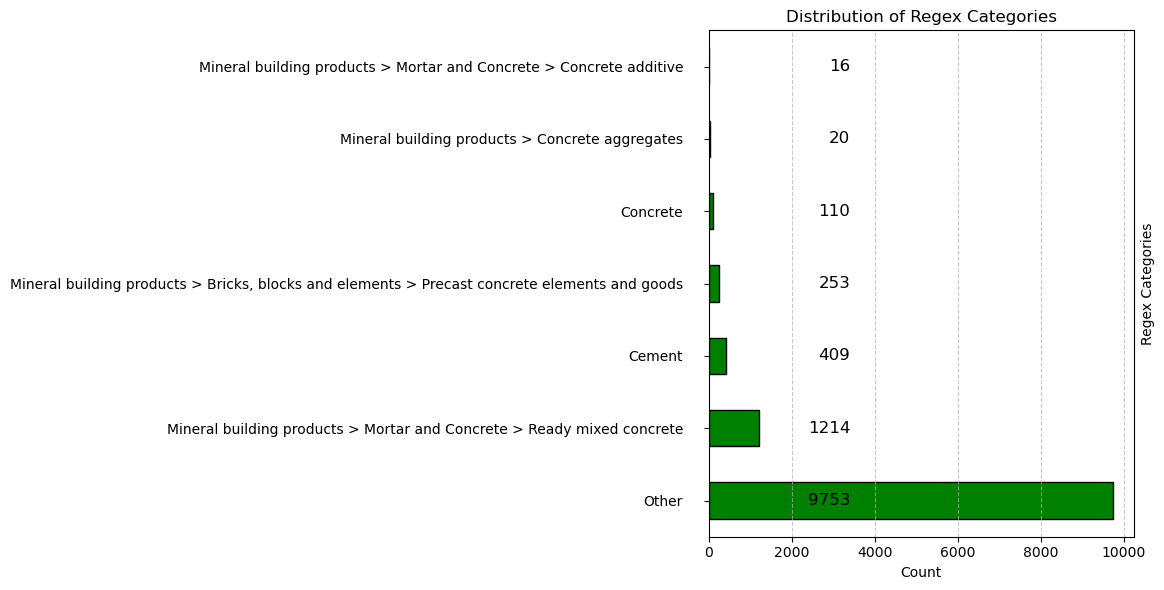

,RegEx Classification,Count
0,Other,9753
1,Mineral building products > Mortar and Concrete > Ready mixed concrete,1214
2,Cement,409
3,"Mineral building products > Bricks, blocks and elements > Precast concrete elements and goods",253
4,Concrete,110
5,Mineral building products > Concrete aggregates,20
6,Mineral building products > Mortar and Concrete > Concrete additive,16


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the CSV file path (adjust as needed)
file_path = "../data/pipeline2/sql/regex_classified/filtered_epd_data02_classified_all_03.csv"

if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Compute the counts of each regex classification
    classification_counts = df["RegEx Classification"].value_counts()
    
    # Convert the counts to a DataFrame for printing
    df_counts = classification_counts.reset_index()
    df_counts.columns = ['RegEx Classification', 'Count']
    
    # Set display options to avoid truncation and line wrapping
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.expand_frame_repr', False)
    pd.set_option('display.width', 1000)
    
    # Create horizontal bar chart
    plt.figure(figsize=(12, 6))
    ax = classification_counts.plot(kind="barh", edgecolor="black", color="green")
    
    # Set axis labels and title
    plt.ylabel("Regex Categories")
    plt.xlabel("Count")
    plt.title("Distribution of Regex Categories")
    
    # Move the y-axis label to the right of the plot
    ax.yaxis.set_label_coords(1.05, 0.5)
    
    # Increase padding on the y-axis tick labels if needed
    ax.tick_params(axis="y", pad=15)
    
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    
    # Determine the maximum count for positioning labels
    max_count = classification_counts.max()
    
    # Add count labels to the left of each bar
    for p in ax.patches:
        count = int(p.get_width())
        # Position the label to the left of the bar (using 35% of max_count as offset)
        label_x = p.get_x() + 0.35 * max_count
        label_y = p.get_y() + p.get_height() / 2
        ax.text(label_x, label_y, str(count),
                horizontalalignment='right', verticalalignment='center',
                color='black', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Print the DataFrame
df_counts

In [70]:
import sqlite3
import pandas as pd
import json

# Define the correct path to your EPD database
DB_PATH = "../data/pipeline2/sql/epd_database.sqlite"

# Connect to the database and fetch each document's classification_system and JSON
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

query = """
    SELECT 
        COALESCE(lower(m.classification_system), 'no explicit classification') AS classification_system,
        d.document
    FROM epd_documents d
    JOIN epd_metadata m ON d.uuid = m.uuid
"""
cursor.execute(query)
rows = cursor.fetchall()
conn.close()

# Define accepted broad category terms (all lower case)
broad_terms = {"construction products, infrastructure & buildings", "construction products"}

# Process each row to determine its category type: "Broad Category", "Missing", or "Adequate"
records = []
for raw_cs, doc_str in rows:
    cs = raw_cs  # classification system from the metadata (already lowercased)
    cat_type = "Missing"  # default assumption
    try:
        doc = json.loads(doc_str)
    except Exception:
        doc = {}

    try:
        classes = doc["processInformation"]["dataSetInformation"]["classificationInformation"]["classification"][0]["class"]
        # Try to get the level 0 value
        candidate = None
        for item in classes:
            if item.get("level", None) == 0:
                candidate = item
                break
        if candidate is None and classes:
            candidate = classes[0]
        if candidate:
            val = candidate.get("value", "").strip()
            if not val:
                cat_type = "Missing"
            elif val.lower() in broad_terms:
                cat_type = "Broad Category"
            else:
                cat_type = "Adequate"
        else:
            cat_type = "Missing"
    except Exception:
        cat_type = "Missing"
    
    records.append({
        "classification_system": cs,
        "cat_type": cat_type
    })

# Create and cache the DataFrame with raw processed records
df_raw = pd.DataFrame(records)

# Optionally display the first few rows to verify the output
# df_raw.head()

# Optionally, save the DataFrame to a CSV file to avoid reprocessing in the future:
# df_raw.to_csv("processed_epd_data.csv", index=False)


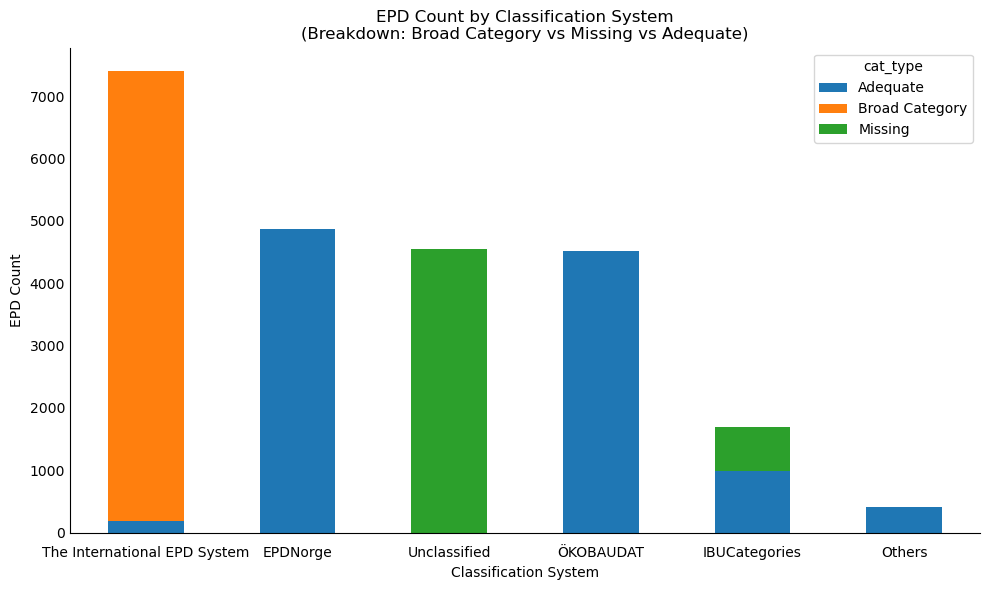

cat_type,Adequate,Broad Category,Missing
classification_system,,,
The International EPD System,188.0,7217.0,1.0
EPDNorge,4872.0,0.0,0.0
Unclassified,0.0,0.0,4551.0
ÖKOBAUDAT,4514.0,0.0,6.0
IBUCategories,994.0,0.0,699.0
Others,404.0,7.0,0.0


In [71]:
import matplotlib.pyplot as plt

# Define the renaming mapping for the classification system
rename_mapping = {
    "the international epd system": "The International EPD System",
    "epdnorge": "EPDNorge",
    "no explicit classification": "Unclassified",
    "oekobau.dat": "ÖKOBAUDAT",
    "ibucategories": "IBUCategories"
}
df_raw["classification_system"] = df_raw["classification_system"].replace(rename_mapping)

# 1. Aggregate counts by classification_system and cat_type
agg_df = df_raw.groupby(["classification_system", "cat_type"]).size().reset_index(name="epd_count")

# 2. Calculate total document count per classification system
totals = df_raw.groupby("classification_system").size().reset_index(name="total_count")

# Merge totals with the aggregated data and relabel systems with < 1000 as "Others"
agg_df = agg_df.merge(totals, on="classification_system", how="left")
low_systems = totals[totals["total_count"] < 1000]["classification_system"].tolist()
agg_df.loc[agg_df["classification_system"].isin(low_systems), "classification_system"] = "Others"

# 3. Re-aggregate after relabeling
final_df = agg_df.groupby(["classification_system", "cat_type"])["epd_count"].sum().reset_index()

# 4. Pivot the data for a stacked bar chart
pivot_df = final_df.pivot(index="classification_system", columns="cat_type", values="epd_count").fillna(0)
pivot_df["Total"] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values("Total", ascending=False)
pivot_df = pivot_df.drop(columns="Total")

# 5. Plot the stacked bar chart
ax = pivot_df.plot(kind="bar", stacked=True, figsize=(10, 6))
ax.set_title("EPD Count by Classification System\n(Breakdown: Broad Category vs Missing vs Adequate)")
ax.set_xlabel("Classification System")
ax.set_ylabel("EPD Count")
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.tick_params(axis='x', pad=10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Optionally display the pivoted DataFrame for inspection
pivot_df


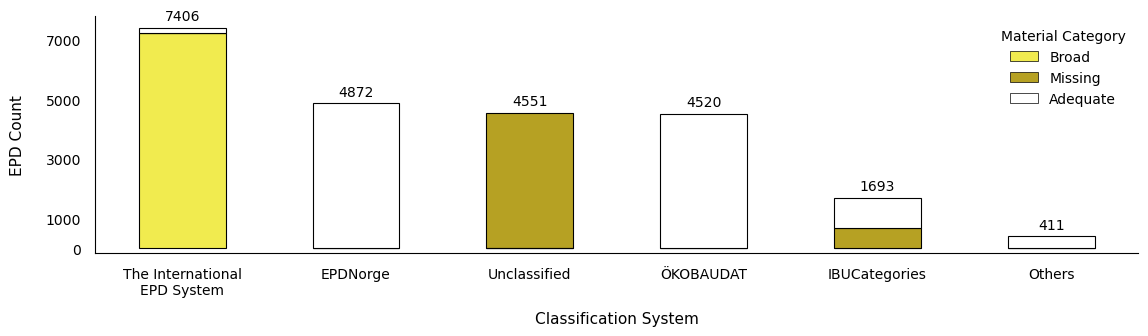

In [175]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# --- Assume pivot_df is already defined ---
# For example, pivot_df might look like:
#                                 Broad Category  Missing  Adequate
# Classification_system1               1234          56       789
# Classification_system2               234           11       567
# etc.

# 1. Define the custom color mapping using the provided colors.
# Here we choose one color for each stacked segment.
color_dict = {
    "Broad Category": "#F1EB4F",  # chosen from your list F1EB4F
    "Missing": "#B6A123",         # chosen from your list
    "Adequate": "white"         # chosen from your list
}

# 2. Ensure pivot_df has the desired columns and order.
desired_order = ["Broad Category", "Missing", "Adequate"]
for col in desired_order:
    if col not in pivot_df.columns:
        pivot_df[col] = 0
pivot_df = pivot_df[desired_order]

# 3. Update the classification system label for "The International EPD System" to use two lines.
pivot_df.rename(index={"The International EPD System": "The International\nEPD System"}, inplace=True)

# 4. Set the figure dimensions in inches (31.9 cm × 9.69 cm converted to inches).
fig_width = 29.42 / 2.54  # ≈ 12.56 inches
fig_height = 8.79 / 2.54  # ≈ 3.81 inches
# fig_width = 23.45 / 2.54  # ≈ 12.56 inches
# fig_height = 9.69 / 2.54  # ≈ 3.81 inches

# 5. Create the stacked bar chart.
ax = pivot_df.plot(kind="bar", stacked=True,
                   figsize=(fig_width, fig_height),
                   color=[color_dict[col] for col in desired_order],
                   linewidth=0.8, 
                   edgecolor="black", 
                #    alpha=0.8, 
                   )

# 7. Remove the black outlines (i.e. do not adjust the patch edgecolor).
# We iterate over the containers to modify the "Adequate" series only.
# for container in ax.containers:
#     # Check the container label: it corresponds to the column name.
#     if container.get_label() == "Adequate":
#         for patch in container:
#             # Remove fill by setting facecolor to 'none'
#             # patch.set_facecolor("white")
#             # Apply a dotted hatch using the same color as defined.
#             # patch.set_hatch("////")
#             # Set the edge color to the chosen color.
#             # patch.set_edgecolor(color_dict["Adequate"])
#             patch.set_edgecolor("black")
#             # You can adjust the hatch line width if desired:
#             patch.set_linewidth(0.8)
#     if container.get_label() != "Adequate":
#         for patch in container:
#             # Set a contrasting edge color (e.g. black) so the border is visible
#             patch.set_edgecolor("black")
#             patch.set_linewidth(0.8)  # Increase the value to see a thicker border

# 8. Annotate each stacked bar with its total count.
totals = pivot_df.sum(axis=1)
for i, total in enumerate(totals):
    offset = totals.max() * 0.02  # small offset for the text placement
    ax.text(i, total + offset, f"{int(total)}",
            ha='center', va='bottom', fontsize=10)

# Create custom legend handles with the correct appearance.
broad_handle = mpatches.Patch(facecolor=color_dict["Broad Category"], label="Broad", edgecolor="black", linewidth=0.5)
missing_handle = mpatches.Patch(facecolor=color_dict["Missing"], label="Missing", edgecolor="black", linewidth=0.5)
# For the Adequate category, use a patch with no fill and the hatch pattern:
adequate_handle = mpatches.Patch(facecolor="none", edgecolor="black", label="Adequate", linewidth=0.5)
# Now update the legend
plt.legend(handles=[broad_handle, missing_handle, adequate_handle], title="Material Category", frameon=False)

# 9. Additional formatting.
# ax.set_title("EPD Count by Classification System\n(Breakdown: Broad Category vs Missing vs Adequate)", fontsize=12)
ax.set_xlabel("Classification System", fontsize=11, labelpad=10)
ax.set_ylabel("EPD Count", fontsize=11, labelpad=15)
# Remove the top and right spines for a cleaner look.
ax.tick_params(axis='both', which='both', length=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='x', pad=10)
ax.tick_params(axis='y', pad=10)

ymin, ymax = ax.get_ylim()
# Increase the bottom margin by reducing ymin by 5% of the current range
ax.set_ylim(ymin - 0.02 * (ymax - ymin), ymax)

ymax = ax.get_ylim()[1]  # Get the current maximum y-value
custom_ticks = [0, 1000] + list(range(3000, int(ymax)+1, 2000))
ax.set_yticks(custom_ticks)

# Set grid to be behind the bars.
# ax.set_axisbelow(True)
# plt.grid(axis="y", linestyle="-", alpha=0.3)

# ax.tick_params(axis='x', pad=10)
plt.xticks(rotation=0, ha="center", fontsize=10)
plt.tight_layout()
plt.show()

# After plotting, get the current y-limits



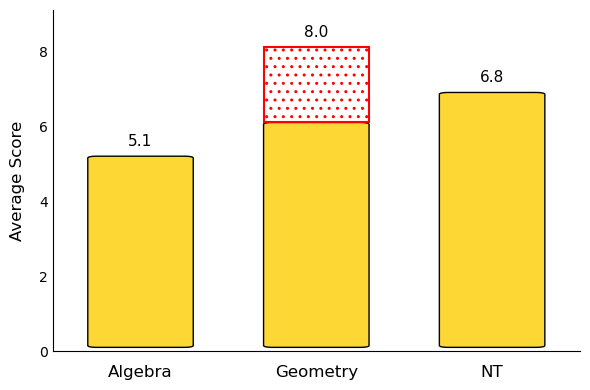

In [65]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.path import Path
from matplotlib.patches import PathPatch

# Data
base_values = [5.1, 6.0, 6.8]
stacked_hatch = [0.0, 2.0, 0.0]  # Only middle bar gets a hatch
labels = ['Algebra', 'Geometry', 'NT']
bar_width = 0.6
bottom_offset = 0.1

# Plot setup
fig, ax = plt.subplots(figsize=(6, 4))

for i, (base, hatch) in enumerate(zip(base_values, stacked_hatch)):
    # Base rounded bar
    rect = FancyBboxPatch(
        (i - bar_width / 2, bottom_offset),
        bar_width,
        base,
        boxstyle="round,pad=0.00,rounding_size=0.05",
        facecolor='#fdd835'
    )
    ax.add_patch(rect)

    # Optional stacked hatch section
    if hatch > 0:
        # Coordinates for top rectangle without bottom edge
        x0 = i - bar_width / 2
        y0 = bottom_offset + base
        x1 = x0 + bar_width
        y1 = y0 + hatch

        verts = [
            (x0, y0),  # bottom-left (move)
            (x0, y1),  # left-top
            (x1, y1),  # right-top
            (x1, y0),  # right-bottom
            (x0, y0),  # close path (but we won't draw the bottom)
        ]

        codes = [
            Path.MOVETO,
            Path.LINETO,
            Path.LINETO,
            Path.LINETO,
            Path.CLOSEPOLY,
        ]

        path = Path(verts, codes)
        hatch_patch = PathPatch(
            path,
            facecolor='none',
            edgecolor='red',
            linewidth=1.5,
            hatch='..'
        )
        ax.add_patch(hatch_patch)
        # ax.add_patch(PathPatch(path, facecolor='none', edgecolor='black', linewidth=1.5)) # Add a black border

    # Label on top
    total = base + hatch
    ax.text(i, bottom_offset + total + 0.2, f'{total:.1f}',
            ha='center', va='bottom', fontsize=11, color='black')

# Axes setup
ax.set_xlim(-0.5, len(base_values) - 0.5)
ax.set_ylim(0, max(base_values[i] + stacked_hatch[i] for i in range(len(base_values))) + bottom_offset + 1)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, fontsize=12)
ax.set_ylabel('Average Score', fontsize=12, labelpad=10)

# Minimalist style
ax.spines[['top', 'right']].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.tick_params(axis='x', pad=10)

plt.tight_layout()
plt.show()
